In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Video
import scipy.stats as sts
from importlib import reload

import gaussian
import utils

sns.set_theme()

Prior distributions $\xi \sim N(\mu, \Sigma)$, $\xi' \sim N(\mu', \Sigma')$

Reference dynamic $\pi^0(\mathbf{x}_{0:N}) = \pi^0_0(\mathbf{x}_0) \prod_{n=0}^{N-1} \pi^0_{n+1|n}(\mathbf{x}_{n+1}|\mathbf{x}_n) = N(\mathbf{x}_0|\mu,\Sigma) \prod_{n=0}^{N-1} N(\mathbf{x}_{n+1}|\mathbf{x}_n,\sigma_n^2 I)$ such that $\pi^0_{N|0}(\mathbf{x}_N|\mathbf{x}_0) = N(\mathbf{x}_N|\mathbf{x}_0,\sigma^2 I)$

where $\sigma^2 = \sum_{n=0}^{N-1} \sigma_n^2$

In particular, $\pi^0_{0,N}(\mathbf{x}_0,\mathbf{x}_N) = \pi^0_0(\mathbf{x}_0) \pi^0_{N|0}(\mathbf{x}_N|\mathbf{x}_0)=N(\mathbf{x}_0|\mu,\Sigma)N(\mathbf{x}_N|\mathbf{x}_0,\sigma^2 I)$

Dynamic SB problem:
$\pi^* = \argmin_{\pi_0=\xi, \pi_N=\xi'} \text{KL}(\pi|\pi^0)$

But we have the disintegration formula:
$\text{KL}(\pi|\pi^0)=\text{KL}(\pi_{0,N}|\pi^0_{0,N}) + \mathbb{E}_{\pi_{0,N}}[KL(\pi_{|0,N}|\pi^0_{|0,N})]$

And thus $\pi^*=\pi^{s,*}\pi^0_{|0,N}$ where $\pi^0_{|0,N}$ is a discrete Brownian bridge from $X_0$ to $X_N$ in time $T=\sigma^2$.

where $\pi^{s,*} = \argmin_{\pi\in\Gamma(\xi,\xi')} \text{KL}(\pi|\pi^0_{0,N})$ (static SB problem)

Here $\xi$ and $\xi'$ are Gaussian and so is $\pi^0_{0,N}$, so $\pi^{s,*}$ is Gaussian as well and can be computed in closed form!

Indeed $\text{KL}(\pi|\pi^0_{0,N}) = -H(\pi) - \mathbb{E}_{\pi}[\log \pi^0_{0,N}(X_0,X_N)] = -H(\pi) - \mathbb{E}_{\pi}[\log \pi^0_0(X_0)] - \mathbb{E}_{\pi}[\log \pi^0_{N|0}(X_N|X_0)] = -H(\pi) - \mathbb{E}_{\pi_0}[\log \pi^0_0(X_0)] + \mathbb{E}_{\pi}[\frac{||X_N-X_0||^2}{2\sigma^2}]$

such that $\pi^{s,*} = \argmin_{\pi\in\Gamma(\xi,\xi')} \mathbb{E}_{\pi}[||X_N-X_0||^2] - 2\sigma^2 H(\pi)$ which can be seen as an entropy-regularized optimal transport problem between gaussian distributions, whose solution is known in closed form! (e.g. <i>The Schrödinger Bridge between Gaussian Measures has a Closed Form</i>)

$$
\pi^\star \sim \mathcal{N} \left( 
\begin{bmatrix}
\mu \\
\mu'
\end{bmatrix},
\begin{bmatrix}
\Sigma & C_\sigma \\
C_\sigma^\top & \Sigma'
\end{bmatrix}
\right).
$$

where 
$$
D_\sigma := \left( 4 \Sigma^{\frac{1}{2}} \Sigma' \Sigma^{\frac{1}{2}} + \sigma^4 I \right)^{\frac{1}{2}}, \quad
C_\sigma := \frac{1}{2} \left( \Sigma^{\frac{1}{2}} D_\sigma \Sigma^{-\frac{1}{2}} - \sigma^2 I \right),
$$

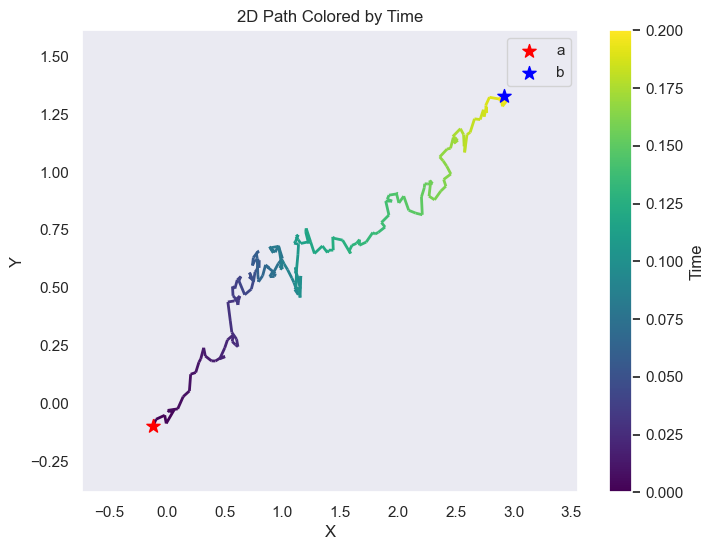

In [199]:
reload(gaussian)
reload(utils)

nu0 = sts.multivariate_normal(mean=[0,0], cov=np.array([[0.1,0.005],[0.005,0.01]]))
nu1 = sts.multivariate_normal(mean=[3,1], cov=np.array([[0.1,0.05],[0.05,0.1]]))

gamma = 0.001
M, N, d = 100, 200, 2


Z = gaussian.sample_dynamic_sb(nu0, nu1, M, N, gamma)
T = N * gamma
t = np.linspace(0, T, N)
utils.plot_path_2d(Z[0], t)

ani = utils.animation_sb_gaussian(Z)

In [200]:
ani.save("animation.mp4", writer="ffmpeg", fps=60)
Video("animation.mp4", embed=True)

In [5]:
import torch 
import math

class PositionalEncoding(torch.nn.Module):
    
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model) # positional encodings
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe) # to make sure pe isn't optimized

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pe[x]

In [34]:
import models
from importlib import reload

In [57]:
reload(models)

pe = models.PositionalEncoder(d_model=16, max_len=20)
model = models.PositionalMLP2d(pe=pe)
x = torch.Tensor([[1,2],[3,4]])
k = torch.IntTensor([0,1])
out = model(x,k)

In [117]:
import data
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets


In [127]:
reload(data)
sampler = data.GaussianSampler(mean=torch.tensor([0,1]),cov=torch.tensor([[1,0],[0,1]]))
sampler = data.TagSampler(tag="swiss")


In [134]:
state_dict = model.state_dict()


In [143]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [144]:
from torch.optim import Adam

In [148]:
type(Adam(model.parameters()))

torch.optim.adam.Adam